# Introduction to LDA and data cleaning
In this notebook, we introduce LDA and what we need for our model. We then proceed to load and clean a sample of the NOW corpus to fulfill our needs.

## What is LDA
[Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) is a statistical model which we will use for topic modelling/discovery. LDA will, given a list of words belonging to a text, output the topics present and their probability. In here, a topic is represented as a probability distribution of words. Thus each text/document will be a distribution over the topics. In short, texts have an associated topic distribution and topics have a word distribution. 

The image below is the plate notation for LDA, where:
* θ<sub>m</sub> is the topic distribution for document m,
* φ<sub>k</sub> is the word distribution for topic k,
* z<sub>mn</sub> is the topic for the n-th word in document m, and
* w<sub>mn</sub> is the specific word.
* α is the parameter of the Dirichlet prior on the per-document topic distributions,
* β is the parameter of the Dirichlet prior on the per-topic word distribution,

![](LDA.png)

α and β are the parameters for the model. A big α means that documents are likely to be represented by a high number of topics and vice versa. Same goes for β, a high value meaning that topics are represented by a high number of words. The number of topics that LDA outputs is dependent on our input and works a bit like clustering. If we allow too many topics we might end up splitting topics uselessly and a too few will make us group them unnecessarily. 

## The NOW corpus
This notebook shows the cleaning process that will be used for the ADA project. Here, only a sample of the data is used (from [here](https://www.corpusdata.org/now_corpus.asp)), but the methods should be the same once scaled to the full database available on the cluster.

The NOW database is composed of billions of words from online newspapers and magazines from 20 different countries. The data we downloaded comes in different files which can be used together or independently. These files are:

1. **now-samples-lexicon.txt**: this is the full dictionnary of the english language, a lexicon. It contains four clolumns, `wID` which is the word id, `word` the actual word, `lemma` which is family of the word (ie: if word is "walked", lemma is "walk") and `PoS` which is the part of speech.
2. **now-samples_sources.txt**: this is the source of every text, in order it contains the text id, the number of words, the date, the country, the website, the url and title of the article.
3. **text.txt**: this file has the complete texts of the articles, the first column is the `textID` in the format @@textID, the second column is the full text, complete with html paragraphs and headers. It is important to note that to prevent plagiarism, every 200 words, 10 words are replaced by the string "@ @ @ @ @ @ @ @ @ @". Combined words are also split, example "can't" is written as "ca n't" and punctuation is surrounded by spaces.
4. **wordLemPoS.txt**: finally, this file contains the `word`, `lemma` and `PoS` for each word in the texts, one by one, so one could read the texts by reading down the columns. Along with that is the `textID` from where the word is and an `ID (seq)` which is a unique indetifier for each word in the database. Each time a word is added this number is incremented.

## What we need from the NOW corpus for LDA
The model will take two inputs, a matrix with all the important words for each text, and a list of all the important words. By important, it is meant the words which will give us good topic modelling. For example, names, locations, simple words like "but, "I" or "and" will not give meaningfull results and are quite common in english (so-called stopwords). Other common words present in our database should be removed too. We also should use lemmas instead of words.

Therefore, the file `wordLemPoS.txt` (hence referred as wlp) is the most important here as it lists all the lemmas with their `textID` associated. Which means that with it we can lsit all the lemmas, remove those we do not want to make our word list, but also group them by texts to create our text-word matrix.

We will also need `now-sample_sources.txt` (hence referred as sources) to link the texts with the information we will deem useful. For example country, date or website.

These are thus the two file we will import and process here with the sample data but also those we will use with the data on the cluster.

## Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

import re
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

from pyspark.mllib.clustering import LDA, LDAModel

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Wlp processing


The goal of this part is to extract the useful data from wlp text files. Since they contain all the words of all the articles and the lemmas to replace them with.

In [2]:
#read the text file and remove the first three rows (zip trick)
wlp_rdd = sc.textFile('sample_data/wordLem_poS.txt').zipWithIndex().filter(lambda r: r[1] > 2).keys()

In [3]:
#we split the elements separated by tabs
lines = wlp_rdd.map(lambda r: r.split('\t'))

#identify the columns
wlp_schema = lines.map(lambda r: Row(textID=int(r[0]),idseq=int(r[1]),word=r[2],lemma=r[3],pos=r[4]))
wlp = spark.createDataFrame(wlp_schema)
wlp.show(5)

+----------+------+----+------+-------+
|     idseq| lemma| pos|textID|   word|
+----------+------+----+------+-------+
|1095362496|      |  fo| 11241|@@11241|
|1095362497|      |null| 11241|    <p>|
|1095362498|   sol| np1| 11241|    Sol|
|1095362499|yurick| np1| 11241| Yurick|
|1095362500|      |   ,| 11241|      ,|
+----------+------+----+------+-------+
only showing top 5 rows



### Word selection
It is very important to select the right words and the right number. The ocncept of "garbage in garbage out" has never been more true than with LDA. When we analyse a text we focus on certain words to extract it's meaning and topic. The same is true here since words like if, for, numbers, common names are not that useful.

Here, we provide and example of the process we will go through. However this is not really a data cleaning step as it will directly influence our model. It is more of a model preprocessing step. We will surely go through many iterations of this next part for our model to give the best results. 

First of all, we can remove all the words which have a PoS which do not interest us. For example number (`mc`,`mc1`,`m#`) or punctuation (`.`,`'`), etc...

Details:
1. `.`,`,`,`'`, `"` are punctuations
2. `null` are html tags from the websites
3. `mc`,`mc1`, `m#` are various numbers and ; thus we remove all PoS starting with m
4. `fo`, `fu`, `fw` are random non sensical words, foreign words; thus we remove all PoS starting with f
5. `np` are proper nouns so we again remove all those that start with np

In [4]:
pos_remove = ['.',',',"\'",'\"','null']
wlp_nopos = wlp.filter(~wlp['pos'].isin(pos_remove)).filter(~wlp['pos'].startswith('m'))\
                        .filter(~wlp['pos'].startswith('f'))\
                        .filter(~wlp['pos'].startswith('np'))\
                        .drop('idseq','pos','word')

Now, we load our list of stopwords, the words that we are not going to use in LDA as they are too common or are proper nouns. We can also remove the rows with no lemmas or those with lemmas that don't make sense or are not common enough.

In [5]:
#np.save('our_stopwords',stopwords)
stopwords = sc.textFile('our_stopwords.txt').collect()
print('Number of stopwords: ', len(stopwords))

Number of stopwords:  5639


In [6]:
#filter out stopwords and looking at the frequency of words without them
wlp_nostop = wlp_nopos.filter(~wlp['lemma'].isin(stopwords))
lemma_freq = wlp_nostop.groupBy('lemma').count().sort('count', ascending=False)
lemma_freq.show()

+----------+-----+
|     lemma|count|
+----------+-----+
|      year| 4272|
|      time| 3169|
|    people| 2912|
|      take| 2667|
|       use| 2244|
|      work| 2137|
|       day| 1750|
|   company| 1698|
|   comment| 1667|
|      need| 1654|
|      want| 1579|
|      look| 1564|
|government| 1551|
|     world| 1550|
|      give| 1480|
|      show| 1478|
|     state| 1475|
|   country| 1464|
|      find| 1464|
|     right| 1408|
+----------+-----+
only showing top 20 rows



We will also remove the most common and least common lemmas. These will be useless since they won't provide enough information for our LDA analysis. Here, we filter out the top 1% and bottom 80% of all lemmas.

In [7]:
#calculate percentiles and filtering out the lemmas above and below them
[bottom,top] = lemma_freq.approxQuantile('count', [0.8,0.99], 0.01)
lemma_tokeep = lemma_freq.filter(lemma_freq['count']>bottom).filter(lemma_freq['count']<top)
c = lemma_tokeep.count()
print('Number of lemmas left: %d'%c)
print('Percentage of lemmas left: %.2f'%(c/lemma_freq.count()*100))

Number of lemmas left: 5430
Percentage of lemmas left: 18.82


Making a inner join, we keep only the words which are in both lists! In the end, we can group the lemmas in their texts to create our text-word matrix. Here we use sql as it is faster than using spark's .join()

In [8]:
#perform sql query and inner join
wlp_nostop.registerTempTable('wlp_nostop')
lemma_tokeep.registerTempTable('lemma_tokeep')

query = """
SELECT wlp_nostop.lemma, wlp_nostop.textID
FROM wlp_nostop
INNER JOIN lemma_tokeep ON wlp_nostop.lemma = lemma_tokeep.lemma
"""

wlp_kept = spark.sql(query)
wlp_bytext = wlp_kept.groupBy('textID').agg(collect_list('lemma'))\
                    .sort('textID')\
                    .withColumnRenamed('collect_list(lemma)','lemma_list')
wlp_bytext.show()

+------+--------------------+
|textID|          lemma_list|
+------+--------------------+
| 11241|[film, film, film...|
| 11242|[online, happen, ...|
| 11243|[slow, thick, day...|
| 11244|[trail, launch, o...|
| 21242|[online, launch, ...|
| 21243|[recognize, indic...|
| 31240|[recognize, inten...|
| 31241|[online, online, ...|
| 31242|[settlement, sett...|
| 41240|[explain, prevent...|
| 41241|[scale, lack, pre...|
| 41244|[everyday, trail,...|
| 51243|[plane, film, pre...|
| 61240|[frustrate, inten...|
| 61242|[editor-in-chief,...|
| 71240|[indicator, requi...|
| 71241|[likelihood, requ...|
| 71242|[film, film, char...|
| 71243|[online, staff, s...|
| 71244|[bone, skull, sku...|
+------+--------------------+
only showing top 20 rows



## Sources
Contains all the additional informations about each text, such as the country, the date, the title, etc...

In [9]:
sources_rdd = sc.textFile('sample_data/now-samples-sources.txt')\
                .map(lambda r: r.split('\t'))

header = sources_rdd.take(3)
sources_rdd = sources_rdd.filter(lambda l: l != header[0])\
                .filter(lambda l: l != header[1])\
                .filter(lambda l: l != header[2])

In [10]:
#create schema and change data type for date
sources_schema = sources_rdd.map(lambda r: Row(textID=int(r[0]),nwords=int(r[1]),date=r[2],country=r[3],website=r[4],url=r[5],title=r[6],)) 
sources = spark.createDataFrame(sources_schema)
#sources = sources.withColumn('date',to_date(sources.date, 'yy-MM-dd'))

In [11]:
sources.printSchema()

root
 |-- country: string (nullable = true)
 |-- date: string (nullable = true)
 |-- nwords: long (nullable = true)
 |-- textID: long (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- website: string (nullable = true)



In [12]:
sources.show(5)

+-------+--------+------+------+--------------------+--------------------+-------------------+
|country|    date|nwords|textID|               title|                 url|            website|
+-------+--------+------+------+--------------------+--------------------+-------------------+
|     US|13-01-06|   397| 11241|Author of The War...|http://kotaku.com...|             Kotaku|
|     US|13-01-06|   757| 11242|That's What They ...|http://michiganra...|     Michigan Radio|
|     US|13-01-06|   755| 11243|Best of New York:...|http://www.nydail...|New York Daily News|
|     US|13-01-06|  1677| 11244|Reflecting on a q...|http://www.oregon...|     OregonLive.com|
|     US|13-01-11|   794| 21242|Ask Ars: Does Fac...|http://arstechnic...|       Ars Technica|
+-------+--------+------+------+--------------------+--------------------+-------------------+
only showing top 5 rows



# Tranformations, LDA and Cross-Validation
Here, we apply the tfidf normalised transformation to transform our list of words into a bag of words type representation. We also perform crossvalidation on the sample data to choose the best hyperparameters that we can then use on the full data on the cluster.

In [13]:
from pyspark.ml.feature import CountVectorizer , IDF, Normalizer
from pyspark.ml.clustering import LDA, LDAModel
#from pyspark.mllib.linalg import Vectors

Can set certain filtering with CountVectorizer, not sure if that's useful since we already do that before hand.

In [14]:
cvmodel = CountVectorizer(inputCol="lemma_list", outputCol="raw_features").fit(wlp_bytext)
result_cv = cvmodel.transform(wlp_bytext).drop('lemma_list')

In [15]:
idfModel = IDF(inputCol="raw_features", outputCol="non_norm_features").fit(result_cv)
result_tfidf = idfModel.transform(result_cv).drop('lemma_list','raw_features')

In [12]:
norm = Normalizer(inputCol="non_norm_features", outputCol="features")
tfidf_norm = norm.transform(result_tfidf).drop('non_norm_features')

## Hyperparameter tunning
There are 3 hyperparameters which we can tune. The number of topics (k), the prior over documents (α or docConcentration for spark) and the prior over topics (β, topicConcentration).

Topic models have metrics that can be used to give them a score and chose the hyperparameters (via crossvalidation for example). The most common are based on loglikelihood like perplexity for LDA. A higher perplexity will mean that the model is better as documents are more closely related to topics. However, perplexity will always decrease with a higher number of topics, as the model becomes better and better at approximating texts (much like k in matrix factorisation). This means that we cannot simply mnimise perplexity to choose k, we have to explore many of them and select an inflexion point or a threshold where the increase in perplexity becomes minimal. 

Furthermore, perplexity has been [shown](http://users.umiacs.umd.edu/~jbg/docs/nips2009-rtl.pdf) to not be correlated with human judgment on the topics described by the model. In fact, they might even be anti correlated. This is why we have decided not to use perplexity as a measure but our own judgment on the topics to chose the best hyperparameters.

### What to chose ?
As a starting place, we belive that the news concentrates on very few topics, for example only 10 such as politics, economy, cooking, sports, etc... This is why we are going to stay with a number of topics in the range of 5-20. This should also prevent excesively fine topics such as "Brexit", "Trump" or "Football" which will be very localised.

Therfore, we will also want the prior over documents to be small so as to not incorporate too many topics in each documents. Similarly, the prior over topics should be large so that each topics contain a wider range of words at its disposal. [Griffiths et al.](http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf) suggest a value of 50/k for α and 0.1 for β. Thus we will look at ranges from [10-30]/k and [0.2-0.4] respectively. Furthermore, [Wallach et al.](http://dirichlet.net/pdf/wallach09rethinking.pdf) suggest to use an asymmetric prior over documents and a symmetric one over topics. Since Spark doesn't learn the asymmetric priors from the data (unlike gensim) we will use [10-30]/(k*topicId).

In [16]:
#spliting the test and training set 
split = result_tfidf.randomSplit([0.8,0.2])
train = split[0]
test = split[1]
alpha_asymmetric = [1/(k+1) for k in range(10)]

In [17]:
lda_model = LDA(k=10, maxIter=100, optimizeDocConcentration=True).setFeaturesCol('non_norm_features').fit(result_tfidf)

In [14]:
list_alpha = np.linspace(1,3,5)
list_beta = np.linspace(0.2,0.4,5)
grid = [[a,b] for a in list_alpha for b in list_beta]
k = 10

for i, g in enumerate(grid):
    alpha_asymmetric = [g[0]/(k+1) for k in range(k)]
    lda_model = LDA(k=k, maxIter=100, docConcentration=alpha_asymmetric,topicConcentration=g[1]).setFeaturesCol('non_norm_features').fit(train)

    topics = lda_model.describeTopics()
    words_topics = topics.toPandas().termIndices
    weight_topics = topics.toPandas().termWeights
    voc = np.array(cvmodel.vocabulary)

    with open('topics.txt','w') as txt:
        for t in range(len(words_topics)):
            txt.write('Topic {}:\n'.format(t))
            for w in range(len(voc[words_topics[t]])):
                line = '%.4f*%s + '%(weight_topics[t][w],voc[words_topics[t][w]])
                if words_topics[t][-1]==words_topics[t][w]: line = '%.4f*%s'%(weight_topics[t][w],voc[words_topics[t][w]])
                txt.write(line)
            txt.write('\n')

    print('{}################### alpha={}, beta={} ###################'.format(i,*g))
    print('################### logPerplexity={}'.format(lda_model.logPerplexity(test)))
    with open('topics.txt','r') as txt:
        for line in txt:
            print(line)

0################### alpha=1.0, beta=0.2 ###################
################### logPerplexity=8.279713103474565
Topic 0:

0.0073*city + 0.0038*police + 0.0036*people + 0.0034*local + 0.0032*community + 0.0031*building + 0.0030*area + 0.0029*book + 0.0027*town + 0.0026*house

Topic 1:

0.0086*film + 0.0080*music + 0.0053*album + 0.0050*movie + 0.0050*show + 0.0045*artist + 0.0040*festival + 0.0037*band + 0.0034*award + 0.0033*actor

Topic 2:

0.0101*game + 0.0065*team + 0.0064*win + 0.0055*play + 0.0055*player + 0.0051*race + 0.0044*cup + 0.0043*league + 0.0043*coach + 0.0036*club

Topic 3:

0.0054*climate + 0.0053*power + 0.0049*oil + 0.0049*prison + 0.0048*energy + 0.0047*court + 0.0039*air + 0.0038*gas + 0.0037*sentence + 0.0037*satellite

Topic 4:

0.0133*comment + 0.0084*police + 0.0071*court + 0.0067*church + 0.0061*web + 0.0057*soldier + 0.0052*civil + 0.0050*recommend + 0.0048*post + 0.0045*delete

Topic 5:

0.0079*score + 0.0074*test + 0.0066*ir + 0.0054*cricket + 0.0050*ball 

5################### alpha=1.5, beta=0.2 ###################
################### logPerplexity=8.28153278236092
Topic 0:

0.0053*city + 0.0046*school + 0.0035*people + 0.0032*student + 0.0029*community + 0.0029*local + 0.0026*building + 0.0025*family + 0.0024*area + 0.0023*public

Topic 1:

0.0069*film + 0.0062*music + 0.0048*tour + 0.0042*show + 0.0041*album + 0.0039*movie + 0.0035*artist + 0.0033*festival + 0.0030*book + 0.0030*award

Topic 2:

0.0106*game + 0.0066*team + 0.0065*win + 0.0055*player + 0.0054*play + 0.0051*race + 0.0045*league + 0.0045*coach + 0.0044*cup + 0.0034*hockey

Topic 3:

0.0060*court + 0.0052*climate + 0.0051*prison + 0.0045*police + 0.0043*oil + 0.0039*air + 0.0038*sentence + 0.0037*satellite + 0.0037*arrest + 0.0037*water

Topic 4:

0.0149*comment + 0.0095*police + 0.0069*web + 0.0065*soldier + 0.0057*recommend + 0.0057*court + 0.0053*civil + 0.0053*post + 0.0051*delete + 0.0046*russian

Topic 5:

0.0092*score + 0.0084*test + 0.0074*ir + 0.0061*cricket + 0.

10################### alpha=2.0, beta=0.2 ###################
################### logPerplexity=8.278862521008271
Topic 0:

0.0048*school + 0.0039*city + 0.0035*cookie + 0.0033*student + 0.0031*people + 0.0029*party + 0.0028*site + 0.0028*use + 0.0027*website + 0.0026*local

Topic 1:

0.0063*film + 0.0057*music + 0.0039*show + 0.0038*album + 0.0036*movie + 0.0034*book + 0.0033*artist + 0.0030*festival + 0.0030*award + 0.0029*tour

Topic 2:

0.0109*game + 0.0068*team + 0.0064*win + 0.0057*player + 0.0054*play + 0.0050*race + 0.0046*league + 0.0045*coach + 0.0045*cup + 0.0035*hockey

Topic 3:

0.0065*police + 0.0064*court + 0.0045*prison + 0.0044*arrest + 0.0039*murder + 0.0037*state + 0.0035*kill + 0.0035*climate + 0.0034*case + 0.0033*republican

Topic 4:

0.0122*comment + 0.0062*police + 0.0054*soldier + 0.0054*web + 0.0051*civil + 0.0048*abuse + 0.0047*recommend + 0.0045*democratic + 0.0044*victim + 0.0042*delete

Topic 5:

0.0091*score + 0.0086*test + 0.0080*ir + 0.0068*cricket + 0.

15################### alpha=2.5, beta=0.2 ###################
################### logPerplexity=8.270366486400185
Topic 0:

0.0052*school + 0.0038*student + 0.0036*city + 0.0032*cookie + 0.0030*people + 0.0028*use + 0.0027*site + 0.0027*child + 0.0025*website + 0.0024*user

Topic 1:

0.0058*film + 0.0053*music + 0.0037*show + 0.0035*album + 0.0034*woman + 0.0033*movie + 0.0033*book + 0.0030*artist + 0.0030*award + 0.0028*festival

Topic 2:

0.0108*game + 0.0067*team + 0.0063*win + 0.0056*player + 0.0053*play + 0.0050*race + 0.0045*league + 0.0045*coach + 0.0044*cup + 0.0034*hockey

Topic 3:

0.0081*police + 0.0076*court + 0.0047*arrest + 0.0046*state + 0.0042*prison + 0.0040*murder + 0.0040*case + 0.0038*kill + 0.0035*republican + 0.0034*death

Topic 4:

0.0110*comment + 0.0068*church + 0.0052*soldier + 0.0049*web + 0.0047*civil + 0.0047*abuse + 0.0045*democratic + 0.0043*recommend + 0.0040*delete + 0.0038*woman

Topic 5:

0.0083*test + 0.0074*cricket + 0.0060*wine + 0.0056*ball + 0.00

20################### alpha=3.0, beta=0.2 ###################
################### logPerplexity=8.26599757243264
Topic 0:

0.0053*school + 0.0041*student + 0.0034*city + 0.0031*cookie + 0.0029*use + 0.0029*people + 0.0028*child + 0.0026*site + 0.0024*user + 0.0024*website

Topic 1:

0.0056*film + 0.0050*music + 0.0035*show + 0.0035*woman + 0.0034*album + 0.0033*book + 0.0032*movie + 0.0029*artist + 0.0029*award + 0.0027*festival

Topic 2:

0.0109*game + 0.0067*team + 0.0063*win + 0.0056*player + 0.0053*play + 0.0052*race + 0.0046*league + 0.0045*cup + 0.0045*coach + 0.0034*hockey

Topic 3:

0.0083*police + 0.0076*court + 0.0048*state + 0.0045*arrest + 0.0041*case + 0.0040*murder + 0.0039*prison + 0.0037*kill + 0.0036*death + 0.0035*indian

Topic 4:

0.0096*comment + 0.0080*church + 0.0048*soldier + 0.0044*web + 0.0044*mother + 0.0043*marriage + 0.0042*civil + 0.0039*recommend + 0.0039*abuse + 0.0037*woman

Topic 5:

0.0105*score + 0.0099*ir + 0.0087*test + 0.0081*cricket + 0.0064*wine 

In [24]:
list_alpha = np.linspace(1,3,5)
list_beta = np.linspace(0.0,0.1,5)
grid = [[a,b] for a in list_alpha for b in list_beta]

for i, g in enumerate(grid):
    lda_model = LDA(k=10, maxIter=100, docConcentration=[g[0]],topicConcentration=g[1]).setFeaturesCol('non_norm_features').fit(result_tfidf) #uses col features by default but just to be sure and explain better

    topics = lda_model.describeTopics()
    words_topics = topics.toPandas().termIndices
    weight_topics = topics.toPandas().termWeights
    voc = np.array(cvmodel.vocabulary)

    with open('topics.txt','w') as txt:
        for t in range(len(words_topics)):
            txt.write('Topic {}:\n'.format(t))
            for w in range(len(voc[words_topics[t]])):
                line = '%.4f*%s + '%(weight_topics[t][w],voc[words_topics[t][w]])
                if words_topics[t][-1]==words_topics[t][w]: line = '%.4f*%s'%(weight_topics[t][w],voc[words_topics[t][w]])
                txt.write(line)
            txt.write('\n')

    print('{}################### alpha={}, beta={} ###################'.format(i,*g))
    with open('topics.txt','r') as txt:
        for line in txt:
            print(line)

0################### alpha=1.0, beta=0.0 ###################
Topic 0:

0.0115*police + 0.0107*court + 0.0084*drug + 0.0062*death + 0.0061*arrest + 0.0061*case + 0.0058*murder + 0.0045*medical + 0.0044*crime + 0.0043*patient

Topic 1:

0.0076*child + 0.0062*woman + 0.0056*school + 0.0046*girl + 0.0043*book + 0.0043*family + 0.0036*life + 0.0036*parent + 0.0035*people + 0.0034*cookie

Topic 2:

0.0061*company + 0.0045*business + 0.0042*market + 0.0037*tax + 0.0036*project + 0.0034*service + 0.0033*industry + 0.0030*investment + 0.0028*financial + 0.0028*cost

Topic 3:

0.0076*club + 0.0072*race + 0.0066*cup + 0.0063*league + 0.0050*win + 0.0047*team + 0.0047*brand + 0.0041*goal + 0.0041*rent + 0.0040*side

Topic 4:

0.0082*party + 0.0068*election + 0.0067*minister + 0.0067*president + 0.0061*government + 0.0058*vote + 0.0057*committee + 0.0055*political + 0.0050*member + 0.0049*state

Topic 5:

0.0089*game + 0.0063*film + 0.0058*music + 0.0054*play + 0.0052*team + 0.0049*win + 0.0045*pla

5################### alpha=1.5, beta=0.0 ###################
Topic 0:

0.0118*police + 0.0106*court + 0.0082*drug + 0.0061*arrest + 0.0060*case + 0.0058*death + 0.0056*murder + 0.0043*patient + 0.0042*crime + 0.0042*medical

Topic 1:

0.0077*child + 0.0063*woman + 0.0057*school + 0.0047*girl + 0.0041*family + 0.0040*book + 0.0040*life + 0.0037*film + 0.0036*parent + 0.0036*people

Topic 2:

0.0062*company + 0.0045*business + 0.0038*tax + 0.0035*project + 0.0035*market + 0.0035*service + 0.0033*industry + 0.0031*investment + 0.0030*financial + 0.0029*bank

Topic 3:

0.0054*hotel + 0.0053*rent + 0.0049*coffee + 0.0047*visa + 0.0046*garden + 0.0046*mortgage + 0.0045*museum + 0.0040*wine + 0.0040*park + 0.0037*brand

Topic 4:

0.0082*party + 0.0068*election + 0.0065*president + 0.0065*minister + 0.0060*government + 0.0057*vote + 0.0057*committee + 0.0055*political + 0.0049*member + 0.0048*state

Topic 5:

0.0090*game + 0.0066*win + 0.0065*team + 0.0056*play + 0.0055*player + 0.0050*music +

10################### alpha=2.0, beta=0.0 ###################
Topic 0:

0.0120*police + 0.0105*court + 0.0081*drug + 0.0061*arrest + 0.0060*case + 0.0056*death + 0.0055*murder + 0.0043*patient + 0.0041*crime + 0.0041*hospital

Topic 1:

0.0078*child + 0.0065*woman + 0.0056*school + 0.0048*girl + 0.0043*film + 0.0042*family + 0.0041*life + 0.0040*book + 0.0037*parent + 0.0036*people

Topic 2:

0.0062*company + 0.0046*business + 0.0038*tax + 0.0036*project + 0.0035*service + 0.0034*industry + 0.0031*investment + 0.0029*market + 0.0029*management + 0.0028*financial

Topic 3:

0.0063*cookie + 0.0052*site + 0.0049*hotel + 0.0046*rent + 0.0043*garden + 0.0041*museum + 0.0041*visa + 0.0039*website + 0.0039*store + 0.0037*visit

Topic 4:

0.0083*party + 0.0069*election + 0.0065*president + 0.0064*minister + 0.0059*government + 0.0057*committee + 0.0055*vote + 0.0054*political + 0.0048*member + 0.0047*state

Topic 5:

0.0093*game + 0.0068*win + 0.0067*team + 0.0058*play + 0.0056*player + 0.0050

15################### alpha=2.5, beta=0.0 ###################
Topic 0:

0.0126*police + 0.0105*court + 0.0079*drug + 0.0061*arrest + 0.0060*case + 0.0054*murder + 0.0051*death + 0.0044*hospital + 0.0044*patient + 0.0042*officer

Topic 1:

0.0082*child + 0.0068*woman + 0.0057*school + 0.0050*girl + 0.0043*family + 0.0042*life + 0.0041*book + 0.0039*film + 0.0039*parent + 0.0036*people

Topic 2:

0.0060*company + 0.0046*business + 0.0038*tax + 0.0037*project + 0.0035*service + 0.0034*industry + 0.0031*investment + 0.0029*management + 0.0028*government + 0.0027*development

Topic 3:

0.0071*cookie + 0.0062*site + 0.0047*hotel + 0.0045*website + 0.0043*rent + 0.0041*garden + 0.0040*visit + 0.0039*museum + 0.0038*visa + 0.0038*store

Topic 4:

0.0084*party + 0.0070*election + 0.0064*president + 0.0063*minister + 0.0058*government + 0.0057*committee + 0.0056*vote + 0.0054*political + 0.0047*state + 0.0046*member

Topic 5:

0.0094*game + 0.0068*win + 0.0068*team + 0.0059*play + 0.0055*player 

20################### alpha=3.0, beta=0.0 ###################
Topic 0:

0.0128*police + 0.0103*court + 0.0078*drug + 0.0060*arrest + 0.0059*case + 0.0052*murder + 0.0048*hospital + 0.0046*patient + 0.0043*medical + 0.0042*officer

Topic 1:

0.0084*child + 0.0071*woman + 0.0058*school + 0.0052*girl + 0.0044*family + 0.0042*life + 0.0041*book + 0.0040*parent + 0.0037*people + 0.0035*film

Topic 2:

0.0058*company + 0.0045*business + 0.0038*project + 0.0038*tax + 0.0035*industry + 0.0034*service + 0.0031*investment + 0.0030*management + 0.0028*government + 0.0028*development

Topic 3:

0.0072*cookie + 0.0064*site + 0.0046*website + 0.0045*hotel + 0.0041*visit + 0.0040*garden + 0.0038*rent + 0.0038*store + 0.0038*museum + 0.0037*visa

Topic 4:

0.0086*party + 0.0072*election + 0.0063*president + 0.0063*minister + 0.0057*vote + 0.0057*government + 0.0057*committee + 0.0054*political + 0.0047*state + 0.0045*member

Topic 5:

0.0095*game + 0.0068*win + 0.0068*team + 0.0061*play + 0.0055*playe

In [20]:
list_alpha = np.linspace(1,3,5)
list_beta = np.linspace(0.0,0.1,5)
grid = [[a,b] for a in list_alpha for b in list_beta]

for i, g in enumerate(grid):
    lda_model = LDA(k=10, maxIter=100, docConcentration=[g[0]],topicConcentration=g[1]).fit(tfidf_norm) #uses col features by default but just to be sure and explain better

    topics = lda_model.describeTopics()
    words_topics = topics.toPandas().termIndices
    weight_topics = topics.toPandas().termWeights
    voc = np.array(cvmodel.vocabulary)

    with open('topics.txt','w') as txt:
        for t in range(len(words_topics)):
            txt.write('Topic {}:\n'.format(t))
            for w in range(len(voc[words_topics[t]])):
                line = '%.4f*%s + '%(weight_topics[t][w],voc[words_topics[t][w]])
                if words_topics[t][-1]==words_topics[t][w]: line = '%.4f*%s'%(weight_topics[t][w],voc[words_topics[t][w]])
                txt.write(line)
            txt.write('\n')

    print('{}################### alpha={}, beta={} ###################'.format(i,*g))
    with open('topics.txt','r') as txt:
        for line in txt:
            print(line)

0################### alpha=1.0, beta=0.0 ###################
Topic 0:

0.0027*police + 0.0021*comment + 0.0019*government + 0.0016*work + 0.0016*take + 0.0016*health + 0.0015*game + 0.0015*court + 0.0015*community + 0.0015*mean

Topic 1:

0.0021*people + 0.0020*win + 0.0020*game + 0.0020*comment + 0.0017*give + 0.0017*family + 0.0017*use + 0.0017*house + 0.0016*police + 0.0016*service

Topic 2:

0.0026*comment + 0.0021*child + 0.0019*police + 0.0018*government + 0.0018*people + 0.0017*team + 0.0017*win + 0.0017*problem + 0.0016*minister + 0.0016*job

Topic 3:

0.0020*day + 0.0020*comment + 0.0020*school + 0.0019*want + 0.0019*team + 0.0018*company + 0.0017*woman + 0.0017*call + 0.0017*find + 0.0016*business

Topic 4:

0.0023*comment + 0.0019*state + 0.0017*game + 0.0017*use + 0.0016*change + 0.0016*police + 0.0015*time + 0.0014*report + 0.0014*service + 0.0014*keep

Topic 5:

0.0022*people + 0.0019*company + 0.0018*want + 0.0018*film + 0.0017*music + 0.0016*city + 0.0016*team + 0.0016*

5################### alpha=1.5, beta=0.0 ###################
Topic 0:

0.0026*police + 0.0021*comment + 0.0019*government + 0.0017*work + 0.0016*take + 0.0015*game + 0.0015*health + 0.0015*community + 0.0015*mean + 0.0014*court

Topic 1:

0.0021*people + 0.0020*win + 0.0020*game + 0.0019*comment + 0.0017*give + 0.0017*use + 0.0017*family + 0.0016*house + 0.0016*police + 0.0015*service

Topic 2:

0.0026*comment + 0.0020*child + 0.0020*police + 0.0018*government + 0.0018*people + 0.0017*win + 0.0017*team + 0.0017*problem + 0.0016*case + 0.0016*work

Topic 3:

0.0020*comment + 0.0020*day + 0.0020*school + 0.0019*company + 0.0018*want + 0.0018*team + 0.0017*woman + 0.0017*call + 0.0017*find + 0.0016*business

Topic 4:

0.0023*comment + 0.0019*state + 0.0017*game + 0.0017*use + 0.0016*change + 0.0016*police + 0.0015*time + 0.0014*report + 0.0014*service + 0.0013*keep

Topic 5:

0.0022*people + 0.0019*company + 0.0018*want + 0.0017*film + 0.0016*city + 0.0016*music + 0.0016*team + 0.0016*lif

10################### alpha=2.0, beta=0.0 ###################
Topic 0:

0.0025*police + 0.0020*comment + 0.0019*government + 0.0017*work + 0.0016*take + 0.0016*game + 0.0015*health + 0.0015*community + 0.0015*mean + 0.0014*people

Topic 1:

0.0021*people + 0.0020*win + 0.0020*game + 0.0019*comment + 0.0017*give + 0.0017*use + 0.0017*family + 0.0016*house + 0.0016*police + 0.0015*service

Topic 2:

0.0026*comment + 0.0020*child + 0.0020*police + 0.0018*government + 0.0018*people + 0.0017*win + 0.0017*team + 0.0017*problem + 0.0016*case + 0.0016*work

Topic 3:

0.0021*comment + 0.0020*day + 0.0020*school + 0.0019*company + 0.0018*want + 0.0018*team + 0.0017*woman + 0.0017*call + 0.0017*find + 0.0016*business

Topic 4:

0.0023*comment + 0.0018*state + 0.0017*use + 0.0017*game + 0.0016*change + 0.0016*police + 0.0015*time + 0.0014*report + 0.0014*service + 0.0013*keep

Topic 5:

0.0022*people + 0.0019*company + 0.0018*want + 0.0016*film + 0.0016*city + 0.0016*team + 0.0016*music + 0.0016*l

15################### alpha=2.5, beta=0.0 ###################
Topic 0:

0.0025*police + 0.0020*comment + 0.0019*government + 0.0017*work + 0.0016*take + 0.0016*game + 0.0015*health + 0.0015*community + 0.0014*mean + 0.0014*people

Topic 1:

0.0021*people + 0.0020*win + 0.0020*game + 0.0019*comment + 0.0017*give + 0.0017*use + 0.0017*family + 0.0016*house + 0.0016*police + 0.0015*service

Topic 2:

0.0026*comment + 0.0020*child + 0.0020*police + 0.0018*government + 0.0018*people + 0.0018*win + 0.0017*team + 0.0017*problem + 0.0016*case + 0.0016*work

Topic 3:

0.0021*comment + 0.0020*day + 0.0020*school + 0.0019*company + 0.0018*want + 0.0018*team + 0.0017*woman + 0.0017*call + 0.0016*find + 0.0016*business

Topic 4:

0.0023*comment + 0.0018*state + 0.0017*use + 0.0017*game + 0.0016*change + 0.0016*police + 0.0015*time + 0.0014*report + 0.0014*service + 0.0013*keep

Topic 5:

0.0022*people + 0.0019*company + 0.0018*want + 0.0016*film + 0.0016*city + 0.0016*team + 0.0016*life + 0.0016*us

20################### alpha=3.0, beta=0.0 ###################
Topic 0:

0.0025*police + 0.0020*comment + 0.0019*government + 0.0017*work + 0.0016*take + 0.0016*game + 0.0015*community + 0.0015*health + 0.0014*mean + 0.0014*people

Topic 1:

0.0021*people + 0.0020*win + 0.0020*game + 0.0019*comment + 0.0017*give + 0.0017*use + 0.0017*family + 0.0016*house + 0.0016*police + 0.0015*service

Topic 2:

0.0026*comment + 0.0020*child + 0.0020*police + 0.0018*government + 0.0018*people + 0.0018*win + 0.0017*team + 0.0017*problem + 0.0016*case + 0.0016*work

Topic 3:

0.0021*comment + 0.0020*day + 0.0020*school + 0.0019*company + 0.0018*want + 0.0018*team + 0.0017*woman + 0.0017*call + 0.0016*find + 0.0016*business

Topic 4:

0.0023*comment + 0.0018*state + 0.0017*use + 0.0017*game + 0.0016*change + 0.0016*police + 0.0015*time + 0.0014*report + 0.0014*service + 0.0013*keep

Topic 5:

0.0022*people + 0.0019*company + 0.0018*want + 0.0016*film + 0.0016*city + 0.0016*team + 0.0016*life + 0.0016*us

# Postprocessing

In [16]:
# Describe topics
topics = lda_model.describeTopics()
words_topics = topics.rdd.map(lambda r: r[1]).collect()
weight_topics = topics.rdd.map(lambda r: r[2]).collect()
voc = cvmodel.vocabulary

In [17]:
with open('topics.txt','w') as txt:
    for t in range(len(words_topics)):
        txt.write('Topic {}:\n'.format(t))
        w_list = [voc[idx] for idx in words_topics[t]]
        for i, w in enumerate(w_list):
            line = '%.4f*%s + '%(weight_topics[t][i],w)
            if w==w_list[-1]: line = '%.4f*%s'%(weight_topics[t][i],w)
            txt.write(line)
        txt.write('\n')

with open('topics.txt','r') as txt:
    for line in txt:
        print(line)

Topic 0:

0.0047*comment + 0.0039*kill + 0.0036*game + 0.0030*family + 0.0030*mother + 0.0029*death + 0.0029*police + 0.0029*attack + 0.0029*day + 0.0028*life

Topic 1:

0.0118*student + 0.0117*school + 0.0088*health + 0.0079*university + 0.0072*education + 0.0071*dr + 0.0069*child + 0.0069*medical + 0.0069*cancer + 0.0060*study

Topic 2:

0.0052*bank + 0.0051*project + 0.0041*energy + 0.0041*tax + 0.0040*government + 0.0038*gas + 0.0037*cent + 0.0037*power + 0.0033*billion + 0.0031*economy

Topic 3:

0.0095*company + 0.0064*business + 0.0055*market + 0.0050*price + 0.0048*share + 0.0044*stock + 0.0043*online + 0.0042*site + 0.0041*investor + 0.0038*buy

Topic 4:

0.0083*police + 0.0082*city + 0.0060*area + 0.0058*water + 0.0058*vehicle + 0.0057*building + 0.0056*refugee + 0.0051*fire + 0.0050*car + 0.0050*road

Topic 5:

0.0072*court + 0.0051*party + 0.0047*government + 0.0046*state + 0.0040*election + 0.0038*president + 0.0036*minister + 0.0035*case + 0.0033*leader + 0.0032*law

Topi

In [223]:
topic_source_bytext = sources.join(result_lda,'textID','inner').drop('url','web','website','lemma_list','raw_features','features').sort('textID')
topic_source_bytext.show()

+------+-------+----------+------+--------------------+--------------------+
|textID|country|      date|nwords|               title|   topicDistribution|
+------+-------+----------+------+--------------------+--------------------+
| 11241|     US|2013-01-06|   397|Author of The War...|[1.28422505531488...|
| 11242|     US|2013-01-06|   757|That's What They ...|[1.08891097726467...|
| 11243|     US|2013-01-06|   755|Best of New York:...|[7.68289358331195...|
| 11244|     US|2013-01-06|  1677|Reflecting on a q...|[3.60786135300145...|
| 21242|     US|2013-01-11|   794|Ask Ars: Does Fac...|[9.69791932332789...|
| 21243|     US|2013-01-11|   690|Accused associate...|[6.87751441501654...|
| 31240|     IE|2013-01-16|   701|Olympic star Conl...|[9.69006522196058...|
| 31241|     IE|2013-01-16|   336|Shakira launches ...|[1.83307816215161...|
| 31242|     IE|2013-01-16|   262|Declan Ganley for...|[2.00487900777354...|
| 41240|     US|2013-01-22|   764|Rape A 'Significa...|[7.82305362400763...|

## Some fun

In [31]:
plt.rcParams['figure.figsize'] = 12, 8

In [224]:
tst_pd = topic_source_bytext.toPandas().set_index('textID')
tst_pd.head()

,country,date,nwords,title,topicDistribution
textID,,,,,
11241,US,2013-01-06,397,"Author of The Warriors, Cult Film Adapted to H...","[0.00012842250553178413, 0.40537235071153876, ..."
11242,US,2013-01-06,757,That's What They Say: Dialect Society chooses ...,"[0.00010889109772676762, 0.11799241690229713, ..."
11243,US,2013-01-06,755,Best of New York: Croissant,"[7.682893583281508e-05, 0.33209947166024273, 0..."
11244,US,2013-01-06,1677,Reflecting on a quarter-century of growth in P...,"[3.607861353013238e-05, 0.9181909885086931, 0...."
21242,US,2013-01-11,794,Ask Ars: Does Facebook auto-delete content aft...,"[9.697919323339782e-05, 0.1895968293727808, 0...."


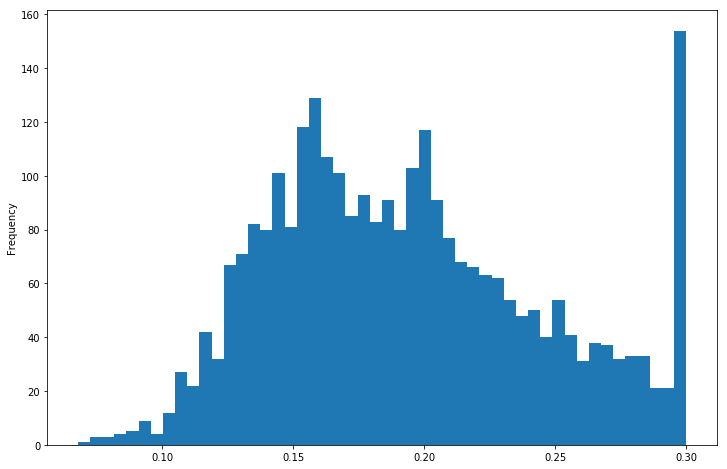

In [225]:
tst_pd.apply(lambda r: np.std(r.topicDistribution),axis=1).plot.hist(bins=50)

We will need to find a way of selecting the topic. The trivial way is to take the one with the maximum weight but this would be disregarding the other topics and their weights. So we can chose only those above a certain threshold, or choose the max only if the std is high enough.

In [226]:
def selectTopic(distr,threshold):
    #suitable max-threshold are from 0 to 1
    #suitable std-threshold are from 0 to 0.3 (maybe a problem)
    if np.std(distr)>=threshold:
        return np.argmax(distr)
    return -999

In [227]:
list_thres = np.linspace(0,0.3,50)
count = []
for t in list_thres:
    count.append(np.count_nonzero(tst_pd.apply(lambda r: selectTopic(r.topicDistribution,t),axis=1)==-999))

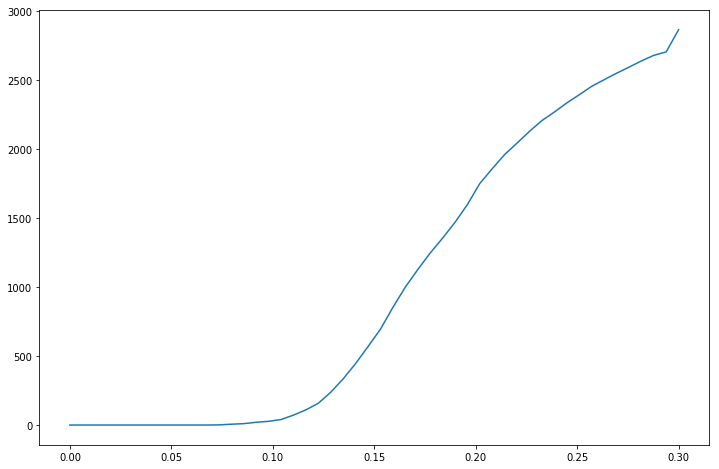

In [228]:
plt.plot(list_thres,count)